In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sync_calcs import calculate_steady_state, spin_husimi_qfunc, spin_S_measure
from sync_plots import angle_xaxis

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode


In [2]:
# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

# Steadt State

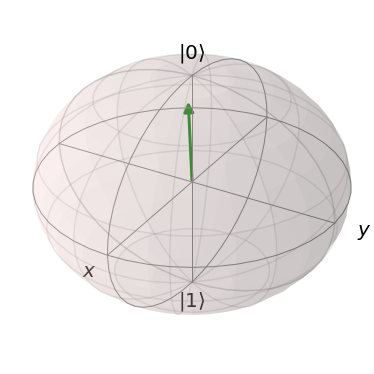

In [3]:
gain_amp=1
loss_amp=0.1

m = min(gain_amp, loss_amp)

ss = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=0.2*m, detuning=0.3*m)

b = Bloch()
b.add_states(ss)
b.show()

# Detuning $\times$ Phase $\times$ $S$

In [4]:
gain_amp=1
loss_amp=0.1

In [5]:
DR = 1
detunings = np.linspace(-DR, DR, n)

In [6]:

S = np.zeros([2*n, n])

for i, D in enumerate(detunings):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=loss_amp, detuning=D)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

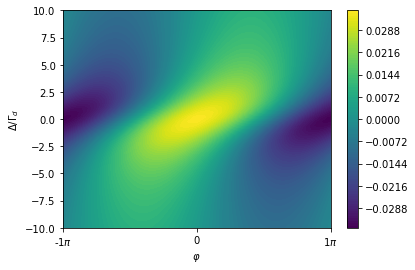

In [7]:
fig, ax = plt.subplots()

DETUNING, PHI = np.meshgrid(detunings / loss_amp, phi)

cquad = ax.contourf(PHI, DETUNING, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

# Strength $\times$ Phase $\times$ $S$

In [8]:
gain_amp=1
loss_amp=0.1

In [9]:
ER = 0.1
strengths = np.linspace(0, ER, n)


In [10]:

S = np.zeros([2*n, n])

for i, E in enumerate(strengths):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=0)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

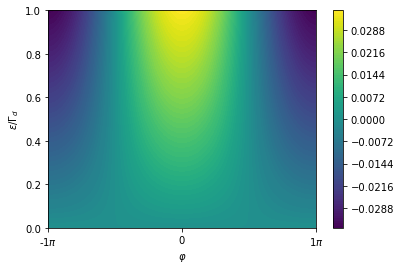

In [11]:
fig, ax = plt.subplots()

STRENGTHS, PHI = np.meshgrid(strengths / loss_amp, phi)

cquad = ax.contourf(PHI, STRENGTHS, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

# Strength $\times$ Detuning $\times$ $\max(S)$

In [12]:
gain_amp=1
loss_amp=0.1

In [13]:
n = 50

DR = 1
detunings = np.linspace(-DR, DR, 2*n)

ER = 0.1
strengths = np.linspace(0, ER, n)

In [14]:
Smax = np.zeros([2 * n, n])

from utils import profile

for i, D in enumerate(detunings):
    for j, E in enumerate(strengths):
        state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=D)
        s = state.full()

        # Swap around dm parts to give correct orientation
        s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
        s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
        Q = spin_husimi_qfunc(state, theta, phi)
        s = spin_S_measure(theta, Q)

        Smax[i, j] = np.max(s)


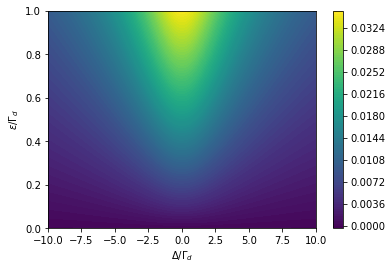

In [15]:
fig, ax = plt.subplots()

DETUNINGS, STRENGTHS  = np.meshgrid(detunings / loss_amp, strengths / loss_amp)

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 100)
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)